In [1]:
from collections import Counter
import os
import random
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
import torch

In [4]:
seed_value = 10

def define_seed(seed_value):
    # Set a seed value
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

define_seed(seed_value)

In [5]:
def get_manual_semantic_set_data(semantic_set_ids_manual):
    #Receives a semantic_set_ids_manual and returns a list of integers (that represent the cluster)
    #e.g. ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6',
    # 'Cluster 7', 'Cluster 8', 'Cluster 9'] -> [0,1,2,3,4,5,6,7,8,9]
    semantic_set_ids_manual_list = [int(cluster.replace('Cluster ','')) for cluster in semantic_set_ids_manual]
    return semantic_set_ids_manual_list


def get_estimator(sequences):
    seq_counter = dict(Counter(sequences))
    dist_support = seq_counter.keys()
    counts = list(seq_counter.values())
    dist_probs = [count/sum(counts) for count in counts]

    return dist_support, torch.tensor(dist_probs)

def entropy(probs):
    log_probs = torch.log(probs)
    entropy = - torch.sum(torch.mul(probs, log_probs))

    return entropy

def align_semantics_sets_with_dist(sentences, semantic_sets, dist_support):
    #Recovers which semantic set each item in the distribution support belongs to
    #Reutrns a list of cluster_ids (aligned with dist_support)
    dist_semantic_sets = []
    for sentence in dist_support:
        index = sentences.index(sentence)
        dist_semantic_sets.append(semantic_sets[index])#.item())

    return dist_semantic_sets

def semantic_entropy(probs, semantic_sets):
    #Adds the probs of elements of the support belonging to the same semantic set to find the probability of
    #each cluster, and then computes semantic entropy
    classes = set(semantic_sets)
    probs_classes = []
    for c in classes:
        probs_items_in_class = torch.where((torch.LongTensor(semantic_sets) == c), probs, torch.zeros(len(probs)))
        prob_class = torch.sum(probs_items_in_class)
        probs_classes.append(prob_class.item())

    sem_entropy = entropy(torch.tensor(probs_classes))
    # return classes, probs_classes, sem_entropy
    return classes, probs_classes, sem_entropy


In [15]:
#Classification labels for correctness ['String matches (fully) one of correct/valid answers', 'String (partly) includes one correct/valid answers',
# 'String includes multiple (but not all) correct/valid answers', 'String includes all correct/valid answers', 'Wrong', 'String expresses inability to answer']
def add_manual_sem_ent(sequences):
    for sample in sequences:
        id_ = sample['id']

        generations = sample['cleaned_text']

        dist_support, dist_probs = get_estimator(generations)

        semantic_set_ids_manual = get_manual_semantic_set_data(sample['semantic_set_ids_manual'])
        dist_semantic_sets = align_semantics_sets_with_dist(generations, semantic_set_ids_manual, dist_support)
        classes, probs_classes, semantic_entropy_value = semantic_entropy(dist_probs, dist_semantic_sets)

        if (sample['greedy_correct_manual'] == 'Wrong') or (sample['greedy_correct_manual'] == 'String expresses inability to answer'):
          greedy_correct_manual_binary = 0
        else:
          greedy_correct_manual_binary = 1

        sample['semantic_entropy_manual'] = semantic_entropy_value.item()
        sample['greedy_correct_manual_binary'] = greedy_correct_manual_binary
        sample['semantic_dist'] = (classes, probs_classes)

    return sequences

In [26]:
def get_relevant_info(data, analysis = 'manual_annotations'):
    sem_ent_entail = [item['semantic_entropy_entail'] for item in data]

    pred_ent = [item['entropy'] for item in data]
    correctness = [item['greedy_correct'] for item in data]

    if analysis == 'manual_annotations':
        try:
            sem_ent_manual = [item['semantic_entropy_manual'] for item in data]
        except:
            sem_ent_manual = []
        correctness_manual = [item['greedy_correct_manual_binary'] for item in data]
    else:
        sem_ent_manual = []
        correctness_manual = []

    return sem_ent_entail, pred_ent, correctness, sem_ent_manual, correctness_manual

In [8]:
def get_dist_support_num(data):
    dist_support_num = [len(item['generations_dist_support']) for item in data]

    return dist_support_num

In [9]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

## Correlating correctness of greedy to correctness of individual answers

In [10]:
def add_manual_correctness(sequences):
    for sample in sequences:
        if (sample['greedy_correct_manual'] == 'Wrong') or (sample['greedy_correct_manual'] == 'String expresses inability to answer'):
            greedy_correct_manual_binary = 0
        # elif sample['greedy_correct_manual'] == 'String expresses inability to answer':
        #     greedy_correct_manual_binary = 1
        else: #correct
            greedy_correct_manual_binary = 1

        sample['greedy_correct_manual_binary'] = greedy_correct_manual_binary

        correctness_samples_manual_binary = []
        for item in sample['correctness_samples_manual']:
            if (item =='Wrong') or (item == 'Inability to answer'):
                correctness_samples_manual_binary.append(0)
            # elif (item == 'Inability to answer'):
            #     correctness_samples_manual_binary.append(1)
            else: #correct
                correctness_samples_manual_binary.append(1)
        sample['correctness_samples_manual_binary'] = correctness_samples_manual_binary

    return sequences

In [11]:
def get_correctness_info(data):
    correct_samples = [item['correctness_samples_manual_binary'] for item in data]
    correctness = [item['greedy_correct_manual_binary'] for item in data]

    return correct_samples, correctness

In [12]:
def run_sequences(path, analysis = 'manual_annotations'):
    with open(path) as f:
        sequences = json.load(f)

    if analysis == 'manual_annotations':
        sequences = add_manual_correctness(sequences)
        correct_samples_manual, correctness_manual = get_correctness_info(sequences)
    else:
        #in the case of automatic annotations
        correct_samples_manual = ['N/A']
        correctness_manual = ['N/A']

    return sequences, correct_samples_manual, correctness_manual

In [13]:
def check_performance_for_adequacy_classifier(correct_samples_manual, correct_proxy):
    flatten_correct_samples_manual = [i for x in correct_samples_manual for i in x]
    flatten_correct_proxy = [i for x in correct_proxy for i in x]

    flatten_correct_samples_manual_clean = [flatten_correct_samples_manual[i] for i in range(len(flatten_correct_samples_manual)) if flatten_correct_proxy[i] != 'Not defined']
    flatten_correct_proxy = [flatten_correct_proxy[i] for i in range(len(flatten_correct_samples_manual)) if flatten_correct_proxy[i] != 'Not defined']

    recall = recall_score(flatten_correct_samples_manual_clean, flatten_correct_proxy)
    precision = precision_score(flatten_correct_samples_manual_clean, flatten_correct_proxy)
    accuracy = accuracy_score(flatten_correct_samples_manual_clean, flatten_correct_proxy)
    f1 = f1_score(flatten_correct_samples_manual_clean, flatten_correct_proxy)
    conf = confusion_matrix(flatten_correct_samples_manual_clean, flatten_correct_proxy)

    return recall, precision, accuracy, f1, conf

In [85]:
def check_predictions(sequences, stored_info):
    predicted_support = [item[stored_info] for item in sequences]
    correct_fact_check_proxy = []
    for gens in predicted_support:
        c_fact_check = []
        for gen in gens:
            if ('true' in gen.lower()) and ('false' in gen.lower()):
                c_fact_check.append('Not defined')
            elif ('false' in gen.lower()):
                c_fact_check.append(0)
            elif ('true' in gen.lower()):
                c_fact_check.append(1)
            else:
                c_fact_check.append('Not defined')

        correct_fact_check_proxy.append(c_fact_check)

    return correct_fact_check_proxy

In [17]:
def normalise_pred_ent(pred_ent, dist_support_num):
    norm_pred_ent = [1 - pred_ent[i]/np.log(dist_support_num[i]) if dist_support_num[i] != 1 else 1 for i in range(len(pred_ent))]
    return norm_pred_ent

In [18]:
def normalise_sem_ent(sem_ent, num_clusters):
    norm_sem_ent = [1 - sem_ent[i]/np.log(num_clusters[i]) if num_clusters[i] != 1 else 1 for i in range(len(pred_ent))] #if there is only 1 cluster we are fully confident in it -> hence, norm_sem_ent = 1
    return norm_sem_ent

In [19]:
def compute_probar(correct_fact_check_proxy):
    correct_fact_check_proxy_clean = [list(filter(lambda a: a != 'Not defined', item)) for item in correct_fact_check_proxy]
    # sum_correct = [sum(item) for item in correct_fact_check_proxy_clean]
    probar = [sum(correct_fact_check_proxy_clean[i])/len(correct_fact_check_proxy_clean[i]) for i in range(len(correct_fact_check_proxy_clean))]

    return probar

In [20]:
def selective_generation(conf_score, correctness):
    selective_performance = []
    thresholds = []
    coverage = []
    for t in range(math.floor(max(conf_score)*100)):
        threshold = t/100
        selective_predicted_correctness = [correctness[i] for i in range(len(correctness)) if conf_score[i] >= threshold]
        items_predicted = len(selective_predicted_correctness)
        accuracy = len([x for x in selective_predicted_correctness if x == True])/items_predicted
        selective_performance.append(accuracy)
        thresholds.append(threshold)
        coverage.append(items_predicted/len(correctness))

    return selective_performance, thresholds, coverage

In [21]:
def get_random_sample_from_list(l,n_samples):
    """Receive a list and randomly sample a number of samples from them (using sampling without replacement)"""
    return random.sample(l, n_samples)

In [22]:
def fact_check_auto_correct_llm_as_judge(sequences, stored_info):
    #Fact check
    predicted_support = [item[stored_info] for item in sequences]
    correct_fact_check_proxy = []
    sum_na = 0
    for gens in predicted_support:
        if ('true' in gens.lower()) and ('false' in gens.lower()):
            sum_na += 1
            correct_fact_check_proxy.append('Not defined')
        elif ('false' in gens.lower()):
            correct_fact_check_proxy.append(0)
        elif ('true' in gens.lower()):
            correct_fact_check_proxy.append(1)
        else:
            sum_na += 1
            correct_fact_check_proxy.append('Not defined')
    return correct_fact_check_proxy


# Analyse AbgCOQA subset of manually annotated data points

In [74]:
# path_name = '/probar/manual_annotations/AbgCOQA/generations_opt2_7b_abgcoqa_manual_samples.json'
# path_name = '/probar/manual_annotations/AbgCOQA/generations_opt6_7b_abgcoqa_manual_samples.json'
# path_name = '/probar/manual_annotations/AbgCOQA/generations_opt13b_abgcoqa_manual_samples.json'
path_name = '/probar/manual_annotations/AbgCOQA/generations_opt30b_abgcoqa_manual_samples.json'


In [75]:
sequences, correct_samples_manual, correctness_manual = run_sequences(path_name)
sem_ent_entail, pred_ent, correctness, sem_ent_manual, correctness_manual = get_relevant_info(sequences)
norm_sem_ent_entail = normalise_sem_ent(sem_ent_entail, [len(set(item['semantic_set_ids_entail'])) for item in sequences])
num_clusters_manual = [len(set(item['semantic_set_ids_manual'])) for item in sequences]
norm_sem_ent_manual = normalise_sem_ent(sem_ent_manual, num_clusters_manual)
dist_support_num = get_dist_support_num(sequences)
norm_pred_ent = normalise_pred_ent(pred_ent, dist_support_num)
prob_true = [np.exp(item['log_prob_true']) for item in sequences]
probar = [item['probar'] for item in sequences]
probar_manual = compute_probar(correct_samples_manual)
greedy_correct_chatgpt = fact_check_auto_correct_llm_as_judge(sequences, 'greedy_plausible_gpt-3.5-turbo_classifier')


In [76]:
correctness = [x['greedy_correct_manual_binary'] for x in sequences] #this is for manually assessed correctness of greedy
# correctness = [int(x['greedy_correct']) for x in sequences] #this is for using thresholded rougeL for correctness of greedy
# correctness = [get_random_sample_from_list(x, 1)[0] for x in correct_samples_manual] #this is for using manually assessed correctness of sample
# correctness = greedy_correct_chatgpt.copy() #this is for using LLM as judge for correctness of greedy

In [77]:
selective_performance_probar_manual, thresholds_probar_manual, coverage_probar_manual = selective_generation(probar_manual, correctness)
selective_performance_probar, thresholds_probar, coverage_probar = selective_generation(probar, correctness)
selective_performance_norm_sem_ent_manual, thresholds_norm_sem_ent_manual, coverage_norm_sem_ent_manual = selective_generation(norm_sem_ent_manual, correctness)
selective_performance_norm_pred_ent, thresholds_norm_pred_ent, coverage_norm_pred_ent = selective_generation(norm_pred_ent, correctness)
selective_performance_norm_sem_ent_entail, thresholds_norm_sem_ent_entail, coverage_norm_sem_ent_entail = selective_generation(norm_sem_ent_entail, correctness)
selective_performance_prob_true, thresholds_prob_true, coverage_prob_true = selective_generation(prob_true, correctness)

# OPT-2.7B`

In [55]:
manual_probar_auroc_opt2_7 = roc_auc_score(correctness, probar_manual)
proxy_probar_auroc_opt2_7 = roc_auc_score(correctness, probar)
manual_norm_sem_ent_auroc_opt2_7 = roc_auc_score(correctness, norm_sem_ent_manual)
manual_sem_ent_auroc_opt2_7 = roc_auc_score([1 - item for item in correctness], sem_ent_manual)
entail_norm_sem_ent_auroc_opt2_7 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt2_7 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt2_7 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt2_7 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt2_7 = roc_auc_score(correctness, prob_true)

manual probar 0.8825000000000001
probar 0.6858333333333333
norm_sem_ent_manual 0.6558333333333333
sem_ent_manual 0.6658333333333333
norm_sem_ent_entail 0.6599999999999999
sem_ent_entail 0.6683333333333333
norm_pred_ent 0.6075
pred_ent 0.6125
prob_true 0.46166666666666667


Text(0.5, 1.0, 'OPT-2.7B Receiver Operator Characteristic Curve')

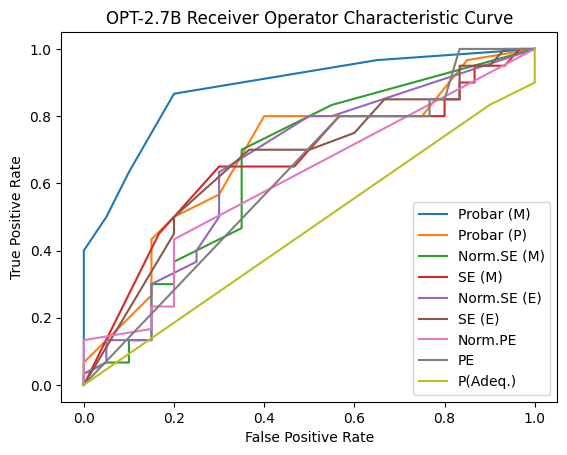

In [57]:
print('manual probar',manual_probar_auroc_opt2_7)
print('probar',proxy_probar_auroc_opt2_7)
print('norm_sem_ent_manual', manual_norm_sem_ent_auroc_opt2_7)
print('sem_ent_manual',manual_sem_ent_auroc_opt2_7)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt2_7)
print('sem_ent_entail',entail_sem_ent_auroc_opt2_7)
print('norm_pred_ent',norm_pred_ent_auroc_opt2_7)
print('pred_ent',pred_ent_auroc_opt2_7)
print('prob_true',prob_true_auroc_opt2_7)

plot_roc_curve(correctness, probar_manual)
plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_manual)
plot_roc_curve([1 - item for item in correctness], sem_ent_manual)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)', 'Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-2.7B Receiver Operator Characteristic Curve')


Text(0.5, 1.0, 'OPT-2.7B')

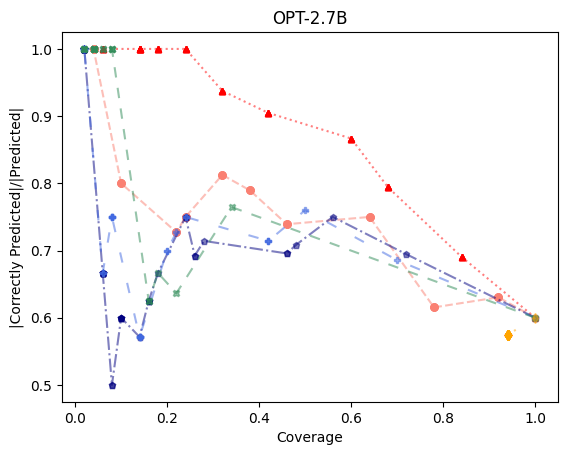

In [58]:
plt.plot(coverage_probar_manual, selective_performance_probar_manual, label = 'Probar(M)', linestyle = 'dotted', marker='^', alpha = 0.5, markersize=5,color = 'red')
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_manual, selective_performance_norm_sem_ent_manual, label = 'Norm.SE(M)', linestyle = 'dashdot', marker='p', alpha = 0.5, markersize=5, color = 'navy')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0,(1,10)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-2.7B")


# OPT-6.7B

In [63]:
manual_probar_auroc_opt6_7 = roc_auc_score(correctness, probar_manual)
proxy_probar_auroc_opt6_7 = roc_auc_score(correctness, probar)
manual_norm_sem_ent_auroc_opt6_7 = roc_auc_score(correctness, norm_sem_ent_manual)
manual_sem_ent_auroc_opt6_7 = roc_auc_score([1 - item for item in correctness], sem_ent_manual)
entail_norm_sem_ent_auroc_opt6_7 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt6_7 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt6_7 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt6_7 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt6_7 = roc_auc_score(correctness, prob_true)

manual probar 0.79265873015873
proxy probar 0.7212301587301587
norm_sem_ent_manual 0.5982142857142858
sem_ent_manual 0.6259920634920635
norm_sem_ent_entail 0.5753968253968254
sem_ent_entail 0.5674603174603174
norm_pred_ent 0.5347222222222222
pred_ent 0.5347222222222223
prob_true 0.4305555555555556


Text(0.5, 1.0, 'OPT-6.7B Receiver Operator Characteristic Curve')

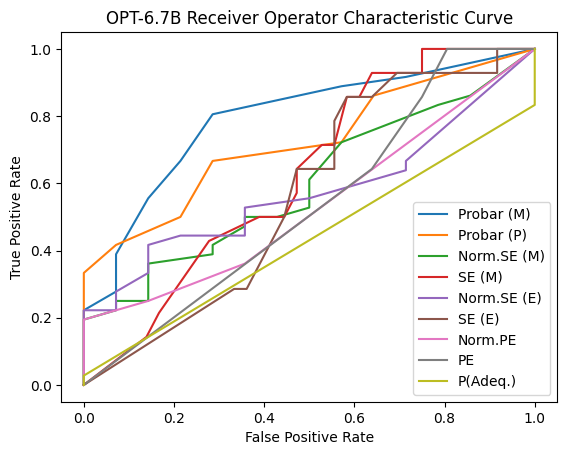

In [64]:
print('manual probar',manual_probar_auroc_opt6_7)
print('proxy probar',proxy_probar_auroc_opt6_7)
print('norm_sem_ent_manual', manual_norm_sem_ent_auroc_opt6_7)
print('sem_ent_manual',manual_sem_ent_auroc_opt6_7)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt6_7)
print('sem_ent_entail',entail_sem_ent_auroc_opt6_7)
print('norm_pred_ent',norm_pred_ent_auroc_opt6_7)
print('pred_ent',pred_ent_auroc_opt6_7)
print('prob_true',prob_true_auroc_opt6_7)

plot_roc_curve(correctness, probar_manual)
plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_manual)
plot_roc_curve([1 - item for item in correctness], sem_ent_manual)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)' ,'Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-6.7B Receiver Operator Characteristic Curve')

Text(0.5, 1.0, 'OPT-6.7B')

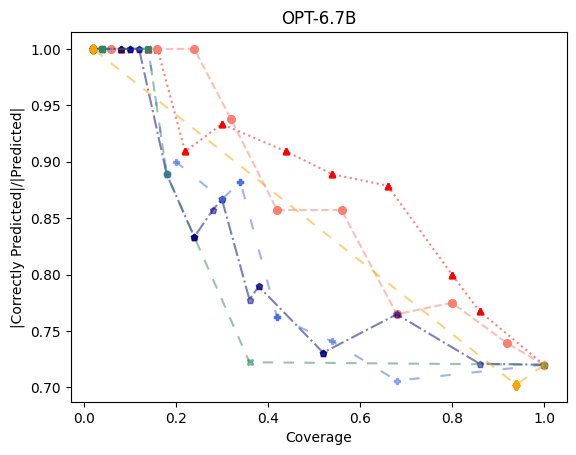

In [65]:
plt.plot(coverage_probar_manual, selective_performance_probar_manual, label = 'Probar(M)', linestyle = 'dotted', marker='^', alpha = 0.5, markersize=5,color = 'red')
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_manual, selective_performance_norm_sem_ent_manual, label = 'Norm.SE(M)', linestyle = 'dashdot', marker='p', alpha = 0.5, markersize=5, color = 'navy')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0,(5,5)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

# plt.legend(loc='upper right')
plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-6.7B")

# OPT13B

In [71]:
manual_probar_auroc_opt13 = roc_auc_score(correctness, probar_manual)
proxy_probar_auroc_opt13 = roc_auc_score(correctness, probar)
manual_norm_sem_ent_auroc_opt13 = roc_auc_score(correctness, norm_sem_ent_manual)
manual_sem_ent_auroc_opt13 = roc_auc_score([1 - item for item in correctness], sem_ent_manual)
entail_norm_sem_ent_auroc_opt13 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt13 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt13 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt13 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt13 = roc_auc_score(correctness, prob_true)

manual probar 0.920997920997921
proxy probar 0.8180873180873182
norm_sem_ent_manual 0.7349272349272349
sem_ent_manual 0.7432432432432432
norm_sem_ent_entail 0.7681912681912682
sem_ent_entail 0.7806652806652806
norm_pred_ent 0.6101871101871101
pred_ent 0.6101871101871102
prob_true 0.4365904365904366


Text(0.5, 1.0, 'OPT-13B Receiver Operator Characteristic Curve')

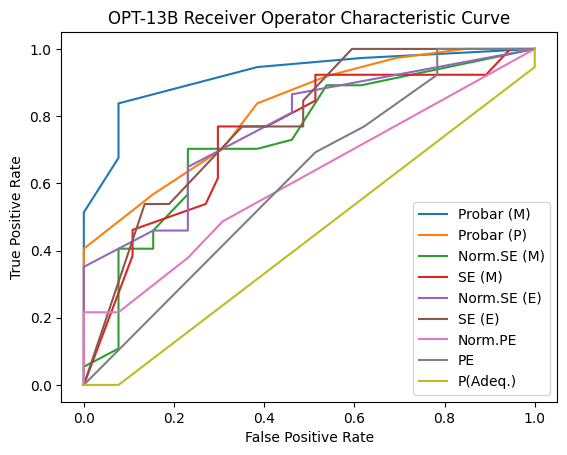

In [72]:
print('manual probar',manual_probar_auroc_opt13)
print('proxy probar',proxy_probar_auroc_opt13)
print('norm_sem_ent_manual', manual_norm_sem_ent_auroc_opt13)
print('sem_ent_manual',manual_sem_ent_auroc_opt13)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt13)
print('sem_ent_entail',entail_sem_ent_auroc_opt13)
print('norm_pred_ent',norm_pred_ent_auroc_opt13)
print('pred_ent',pred_ent_auroc_opt13)
print('prob_true',prob_true_auroc_opt13)

plot_roc_curve(correctness, probar_manual)
plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_manual)
plot_roc_curve([1 - item for item in correctness], sem_ent_manual)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)','Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-13B Receiver Operator Characteristic Curve')


Text(0.5, 1.0, 'OPT-13B')

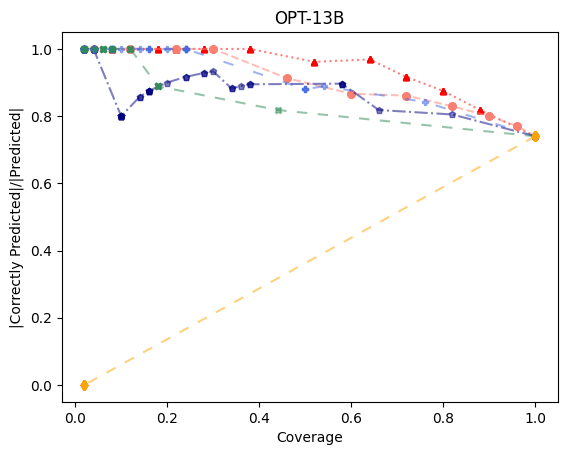

In [73]:
plt.plot(coverage_probar_manual, selective_performance_probar_manual, label = 'Probar(M)', linestyle = 'dotted', marker='^', alpha = 0.5, markersize=5,color = 'red')
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_manual, selective_performance_norm_sem_ent_manual, label = 'Norm.SE(M)', linestyle = 'dashdot', marker='p', alpha = 0.5, markersize=5, color = 'navy')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0,(5,5)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-13B")

# OPT30B

In [78]:
manual_probar_auroc_opt30 = roc_auc_score(correctness, probar_manual)
proxy_probar_auroc_opt30 = roc_auc_score(correctness, probar)
manual_norm_sem_ent_auroc_opt30 = roc_auc_score(correctness, norm_sem_ent_manual)
manual_sem_ent_auroc_opt30 = roc_auc_score([1 - item for item in correctness], sem_ent_manual)
entail_norm_sem_ent_auroc_opt30 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt30 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt30 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt30 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt30 = roc_auc_score(correctness, prob_true)

manual probar 0.9126838235294118
proxy probar 0.7674632352941175
norm_sem_ent_manual 0.6424632352941178
sem_ent_manual 0.6590073529411764
norm_sem_ent_entail 0.5735294117647058
sem_ent_entail 0.5790441176470589
norm_pred_ent 0.5891544117647058
pred_ent 0.5928308823529411
prob_true 0.3988970588235294


Text(0.5, 1.0, 'OPT-30B Receiver Operator Characteristic Curve')

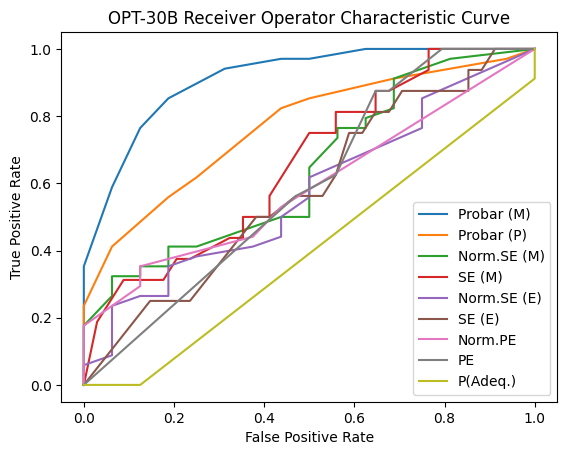

In [79]:
print('manual probar',manual_probar_auroc_opt30)
print('proxy probar',proxy_probar_auroc_opt30)
print('norm_sem_ent_manual', manual_norm_sem_ent_auroc_opt30)
print('sem_ent_manual',manual_sem_ent_auroc_opt30)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt30)
print('sem_ent_entail',entail_sem_ent_auroc_opt30)
print('norm_pred_ent',norm_pred_ent_auroc_opt30)
print('pred_ent',pred_ent_auroc_opt30)
print('prob_true',prob_true_auroc_opt30)

plot_roc_curve(correctness, probar_manual)
plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_manual)
plot_roc_curve([1 - item for item in correctness], sem_ent_manual)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)','Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-30B Receiver Operator Characteristic Curve')


Text(0.5, 1.0, 'OPT-30B')

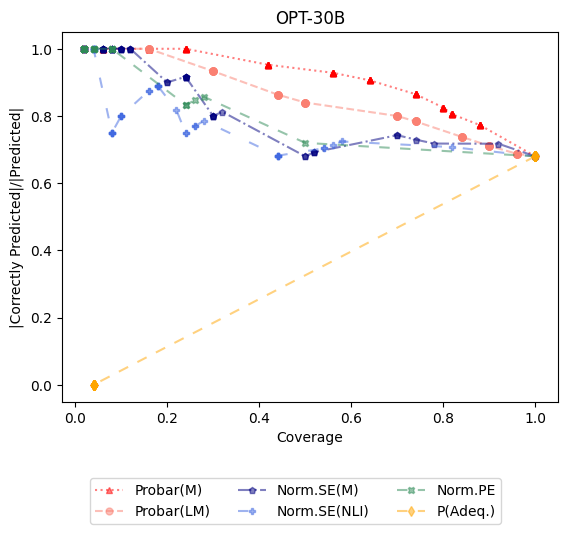

In [80]:
plt.plot(coverage_probar_manual, selective_performance_probar_manual, label = 'Probar(M)', linestyle = 'dotted', marker='^', alpha = 0.5, markersize=5,color = 'red')
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_manual, selective_performance_norm_sem_ent_manual, label = 'Norm.SE(M)', linestyle = 'dashdot', marker='p', alpha = 0.5, markersize=5, color = 'navy')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0,(5, 5)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.legend(loc='lower right', ncol=3, bbox_to_anchor=(0.9, -0.35))
plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-30B")


# Results on dev-test sets on mixed ambig-non ambig datapoints

In [194]:
# #OPT2.7B
# path_dev_ambig = '/probar/generations/AbgCOQA/sequencesopt-2.7b_dev_ambiguous.json'
# path_dev_non_ambig = '/probar/generations/AbgCOQA/sequencesopt-2.7b_dev_non_ambiguous.json'
# path_test_ambig = '/probar/generations/AbgCOQA/sequencesopt-2.7b_test_ambiguous.json'
# path_test_non_ambig = '/probar/generations/AbgCOQA/sequencesopt-2.7b_test_non_ambiguous.json'

#OPT6.7B
# path_dev_ambig = '/probar/generations/AbgCOQA/sequencesopt-6.7b_dev_ambiguous.json'
# path_dev_non_ambig = '/probar/generations/AbgCOQA/sequencesopt-6.7b_dev_non_ambiguous.json'
# path_test_ambig = '/probar/generations/AbgCOQA/sequencesopt-6.7b_test_ambiguous.json'
# path_test_non_ambig = '/probar/generations/AbgCOQA/sequencesopt-6.7b_test_non_ambiguous.json'

#OPT13B
# path_dev_ambig = '/probar/generations/AbgCOQA/sequencesopt-13b_dev_ambiguous.json'
# path_dev_non_ambig = '/probar/generations/AbgCOQA/sequencesopt-13b_dev_non_ambiguous.json'
# path_test_ambig = '/probar/generations/AbgCOQA/sequencesopt-13b_test_ambiguous.json'
# path_test_non_ambig = '/probar/generations/AbgCOQA/sequencesopt-13b_test_non_ambiguous.json'

#OPT30B
path_dev_ambig = '/probar/generations/AbgCOQA/sequencesopt-30b_dev_ambiguous.json'
path_dev_non_ambig = '/probar/generations/AbgCOQA/sequencesopt-30b_dev_non_ambiguous.json'
path_test_ambig = '/probar/generations/AbgCOQA/sequencesopt-30b_test_ambiguous.json'
path_test_non_ambig = '/probar/generations/AbgCOQA/sequencesopt-30b_test_non_ambiguous.json'

sequences_dev_ambig, correct_samples_manual, correctness_manual = run_sequences(path_dev_ambig, 'automatic_annotations')

sequences_test_ambig, correct_samples_manual, correctness_manual = run_sequences(path_test_ambig, 'automatic_annotations')

sequences_dev_non_ambig, correct_samples_manual, correctness_manual = run_sequences(path_dev_non_ambig, 'automatic_annotations')

sequences_test_non_ambig, correct_samples_manual, correctness_manual = run_sequences(path_test_non_ambig, 'automatic_annotations')

sequences_ambig = sequences_test_ambig
sequences_non_ambig = sequences_test_non_ambig
sequences_total = sequences_test_ambig + sequences_test_non_ambig

# sequences_ambig = sequences_dev_ambig
# sequences_non_ambig = sequences_dev_non_ambig
# sequences_total = sequences_dev_ambig + sequences_dev_non_ambig


In [195]:
# sequences = sequences_ambig.copy()
# sequences = sequences_non_ambig.copy()
sequences = sequences_total.copy()

In [196]:
sem_ent_entail, pred_ent, correctness, sem_ent_manual, correctness_manual = get_relevant_info(sequences, 'automatic_annotations')

dist_support_num = get_dist_support_num(sequences)

norm_pred_ent = normalise_pred_ent(pred_ent, dist_support_num)
norm_sem_ent_entail = normalise_sem_ent(sem_ent_entail, [len(set(item['semantic_set_ids_entail'])) for item in sequences])

correct_fact_check_proxy = check_predictions(sequences,  'predicted_support_medium_classifier')
probar = [item['probar'] for item in sequences]

prob_true = [np.exp(item['log_prob_true']) for item in sequences]

greedy_correct_llm_as_a_judge = fact_check_auto_correct_llm_as_judge(sequences, 'greedy_plausible_gpt-3.5-turbo_classifier')

In [197]:
# correctness = [x['greedy_correct'] for x in sequences] #this is the correctness of the greedy for the rougeL correctness assessment criterion
correctness = greedy_correct_llm_as_a_judge.copy() #this is the correctness of the greedy for ChatgPT as a judge correctness assessment criterion

In [198]:
selective_performance_probar, thresholds_probar, coverage_probar = selective_generation(probar, correctness)
selective_performance_norm_pred_ent, thresholds_norm_pred_ent, coverage_norm_pred_ent = selective_generation(norm_pred_ent, correctness)
selective_performance_norm_sem_ent_entail, thresholds_norm_sem_ent_entail, coverage_norm_sem_ent_entail = selective_generation(norm_sem_ent_entail, correctness)
selective_performance_prob_true, thresholds_prob_true, coverage_prob_true = selective_generation(prob_true, correctness)

# Ambiguous Test set

## OPT2.7B

In [108]:
proxy_probar_auroc_opt2_7 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt2_7 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt2_7 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt2_7 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt2_7 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt2_7 = roc_auc_score(correctness, prob_true)

proxy probar 0.7122156013001084
norm_sem_ent_entail 0.6457204767063922
sem_ent_entail 0.638136511375948
norm_pred_ent 0.5846424702058506
pred_ent 0.5841007583965331
prob_true 0.5342632719393283


Text(0.5, 1.0, 'OPT-2.7B Receiver Operator Characteristic Curve')

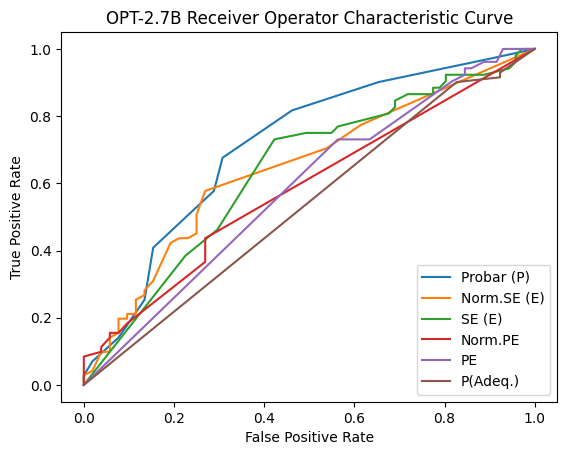

In [109]:
print('proxy probar',proxy_probar_auroc_opt2_7)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt2_7)
print('sem_ent_entail',entail_sem_ent_auroc_opt2_7)
print('norm_pred_ent',norm_pred_ent_auroc_opt2_7)
print('pred_ent',pred_ent_auroc_opt2_7)
print('prob_true',prob_true_auroc_opt2_7)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (P)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-2.7B Receiver Operator Characteristic Curve')


Text(0.5, 1.0, 'OPT-2.7B')

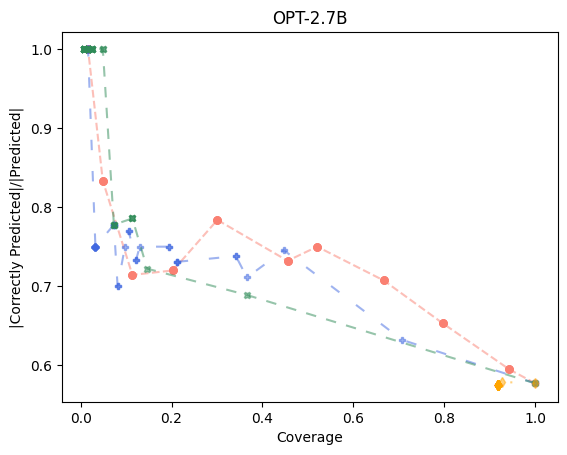

In [110]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0,(1,10)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-2.7B")


## OPT-6.7B

In [118]:
proxy_probar_auroc_opt6_7 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt6_7 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt6_7 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt6_7 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt6_7 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt6_7 = roc_auc_score(correctness, prob_true)

proxy probar 0.7328042328042328
norm_sem_ent_entail 0.6012639623750735
sem_ent_entail 0.6189006466784245
norm_pred_ent 0.5477660199882421
pred_ent 0.5480599647266314
prob_true 0.5149911816578483


Text(0.5, 1.0, 'OPT-6.7B Receiver Operator Characteristic Curve')

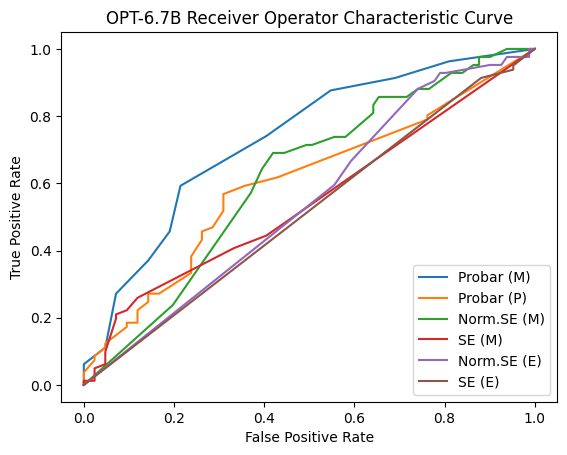

In [119]:
print('proxy probar',proxy_probar_auroc_opt6_7)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt6_7)
print('sem_ent_entail',entail_sem_ent_auroc_opt6_7)
print('norm_pred_ent',norm_pred_ent_auroc_opt6_7)
print('pred_ent',pred_ent_auroc_opt6_7)
print('prob_true',prob_true_auroc_opt6_7)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)', 'Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-6.7B Receiver Operator Characteristic Curve')

Text(0.5, 1.0, 'OPT-6.7B')

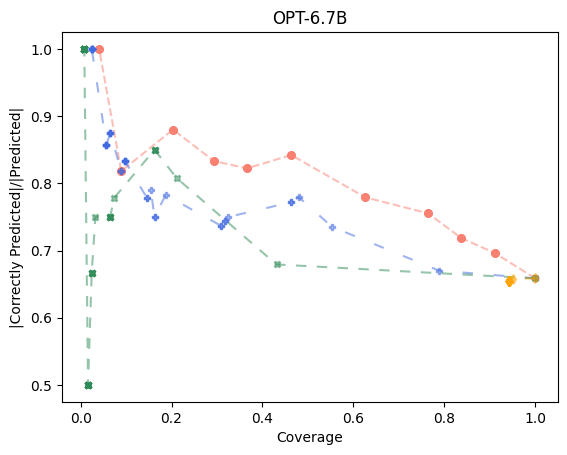

In [120]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0, (5, 5)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-6.7B")

## OPT13B

In [127]:
proxy_probar_auroc_opt13 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt13 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt13 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt13 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt13 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt13 = roc_auc_score(correctness, prob_true)

proxy probar 0.6916408668730651
norm_sem_ent_entail 0.6074303405572755
sem_ent_entail 0.606811145510836
norm_pred_ent 0.5024767801857585
pred_ent 0.5058823529411764
prob_true 0.5058823529411764


Text(0.5, 1.0, 'OPT-13B Receiver Operator Characteristic Curve')

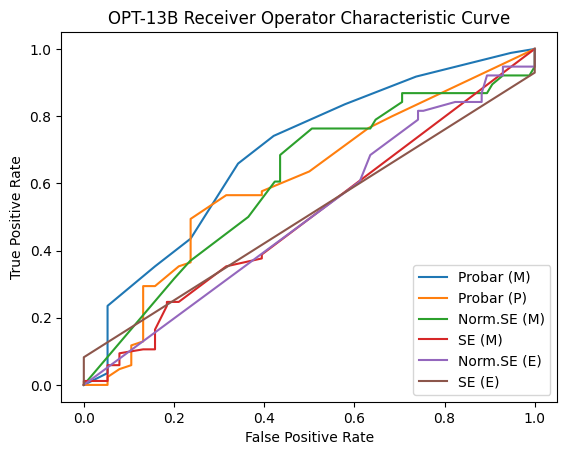

In [128]:
print('proxy probar',proxy_probar_auroc_opt13)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt13)
print('sem_ent_entail',entail_sem_ent_auroc_opt13)
print('norm_pred_ent',norm_pred_ent_auroc_opt13)
print('pred_ent',pred_ent_auroc_opt13)
print('prob_true',prob_true_auroc_opt13)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)','Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-13B Receiver Operator Characteristic Curve')


Text(0.5, 1.0, 'OPT-13B')

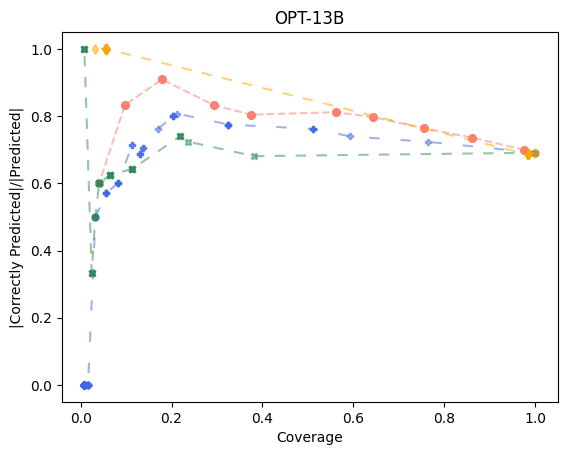

In [129]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0, (5, 5)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-13B")

## OPT30B

In [135]:
proxy_probar_auroc_opt30 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt30 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt30 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt30 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt30 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt30 = roc_auc_score(correctness, prob_true)

proxy probar 0.6632530120481928
norm_sem_ent_entail 0.6615963855421687
sem_ent_entail 0.6634036144578312
norm_pred_ent 0.6504518072289156
pred_ent 0.6501506024096386
prob_true 0.5403614457831325


Text(0.5, 1.0, 'OPT-30B Receiver Operator Characteristic Curve')

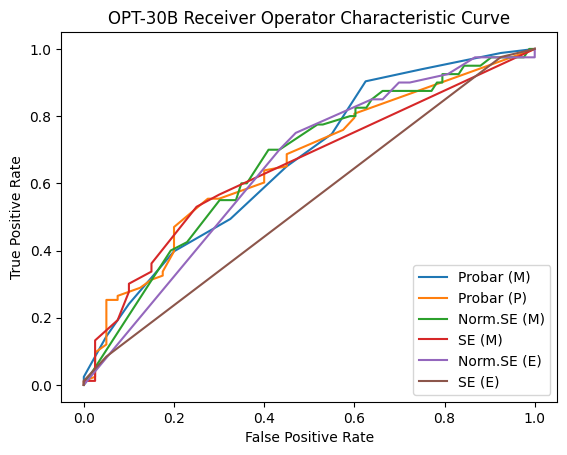

In [136]:
print('proxy probar',proxy_probar_auroc_opt30)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt30)
print('sem_ent_entail',entail_sem_ent_auroc_opt30)
print('norm_pred_ent',norm_pred_ent_auroc_opt30)
print('pred_ent',pred_ent_auroc_opt30)
print('prob_true',prob_true_auroc_opt30)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)','Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-30B Receiver Operator Characteristic Curve')

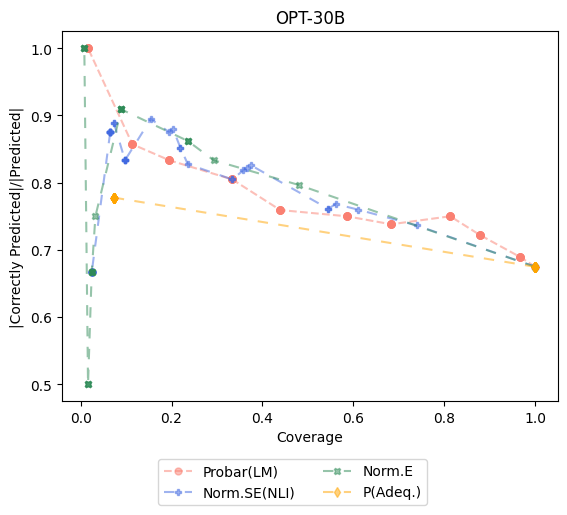

In [137]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 5)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
# plt.plot(coverage_norm_sem_ent, selective_performance_norm_sem_ent, label = 'Norm. SE(NC)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5)
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.E', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0, (5, 5)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

# plt.legend(loc='upper right')
plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-30B")
plt.legend(loc='lower right', ncol=2, bbox_to_anchor=(0.75, -0.3))
plt.savefig('selective_gen_mixed_dev_4.pdf', format="pdf",bbox_inches='tight')

# Non Ambiguous Test set

## OPT2.7B

In [143]:
proxy_probar_auroc_opt2_7 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt2_7 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt2_7 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt2_7 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt2_7 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt2_7 = roc_auc_score(correctness, prob_true)

proxy probar 0.6901611047180667
norm_sem_ent_entail 0.541283084004603
sem_ent_entail 0.5401323360184119
norm_pred_ent 0.41268699654775604
pred_ent 0.41211162255466055
prob_true 0.45799769850402766


Text(0.5, 1.0, 'OPT-2.7B Receiver Operator Characteristic Curve')

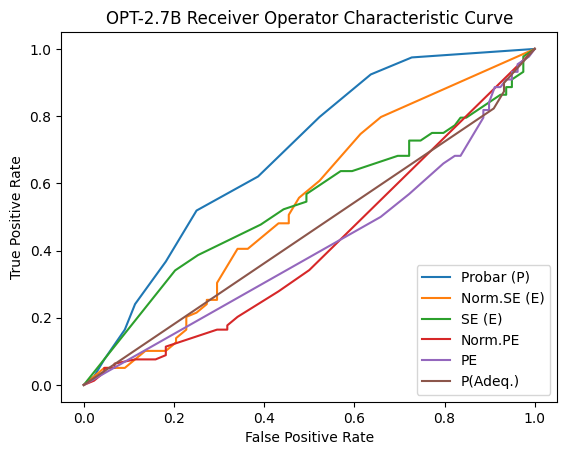

In [144]:
print('proxy probar',proxy_probar_auroc_opt2_7)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt2_7)
print('sem_ent_entail',entail_sem_ent_auroc_opt2_7)
print('norm_pred_ent',norm_pred_ent_auroc_opt2_7)
print('pred_ent',pred_ent_auroc_opt2_7)
print('prob_true',prob_true_auroc_opt2_7)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (P)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-2.7B Receiver Operator Characteristic Curve')

Text(0.5, 1.0, 'OPT-2.7B')

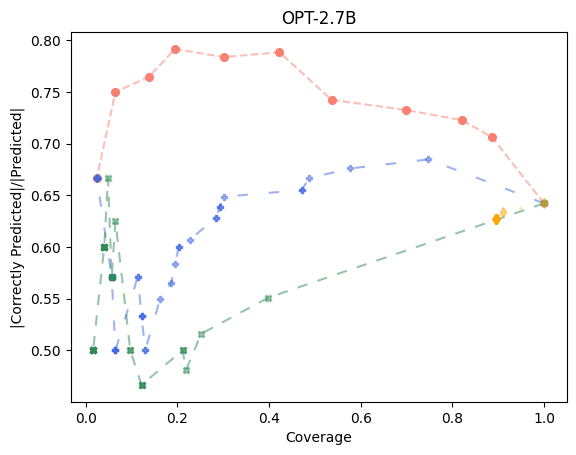

In [145]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0,(1,10)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-2.7B")


## OPT6.7B

In [151]:
proxy_probar_auroc_opt6_7 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt6_7 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt6_7 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt6_7 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt6_7 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt6_7 = roc_auc_score(correctness, prob_true)

proxy probar 0.7128330995792426
norm_sem_ent_entail 0.5974754558204769
sem_ent_entail 0.5967741935483871
norm_pred_ent 0.5559256661991584
pred_ent 0.5531206171107995
prob_true 0.4838709677419355


Text(0.5, 1.0, 'OPT-6.7B Receiver Operator Characteristic Curve')

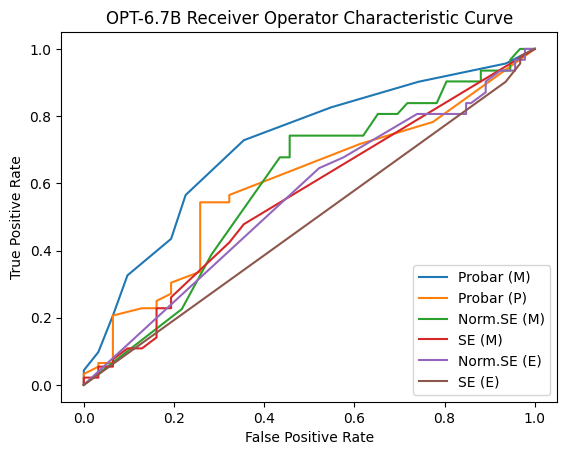

In [152]:
print('proxy probar',proxy_probar_auroc_opt6_7)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt6_7)
print('sem_ent_entail',entail_sem_ent_auroc_opt6_7)
print('norm_pred_ent',norm_pred_ent_auroc_opt6_7)
print('pred_ent',pred_ent_auroc_opt6_7)
print('prob_true',prob_true_auroc_opt6_7)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)', 'Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-6.7B Receiver Operator Characteristic Curve')

Text(0.5, 1.0, 'OPT-6.7B')

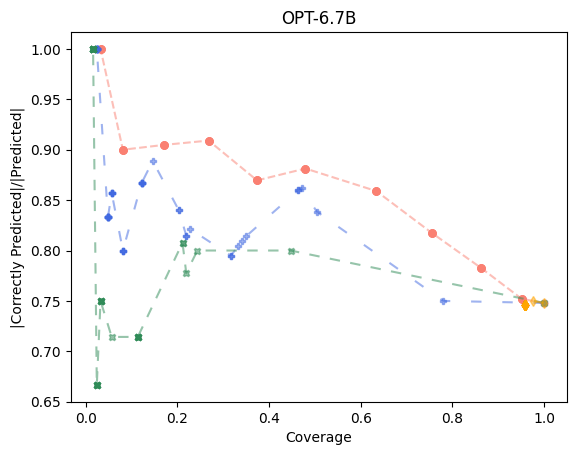

In [153]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0, (5, 5)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-6.7B")

## OPT13B

In [159]:
proxy_probar_auroc_opt13 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt13 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt13 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt13 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt13 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt13 = roc_auc_score(correctness, prob_true)

proxy probar 0.7793417922283901
norm_sem_ent_entail 0.6346153846153846
sem_ent_entail 0.6191514670896114
norm_pred_ent 0.535289452815226
pred_ent 0.5348929421094369
prob_true 0.5614591593973037


Text(0.5, 1.0, 'OPT-13B Receiver Operator Characteristic Curve')

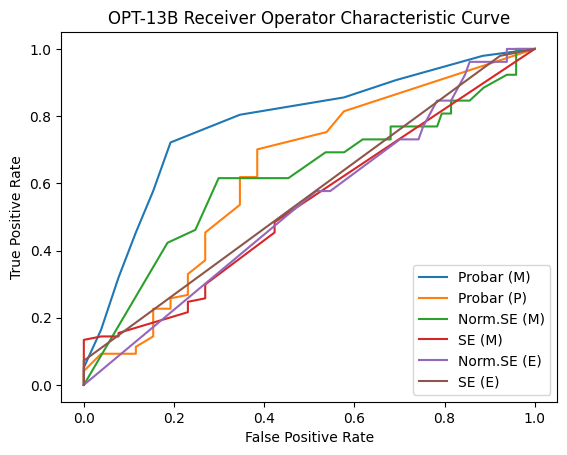

In [160]:
print('proxy probar',proxy_probar_auroc_opt13)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt13)
print('sem_ent_entail',entail_sem_ent_auroc_opt13)
print('norm_pred_ent',norm_pred_ent_auroc_opt13)
print('pred_ent',pred_ent_auroc_opt13)
print('prob_true',prob_true_auroc_opt13)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)','Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-13B Receiver Operator Characteristic Curve')

Text(0.5, 1.0, 'OPT-13B')

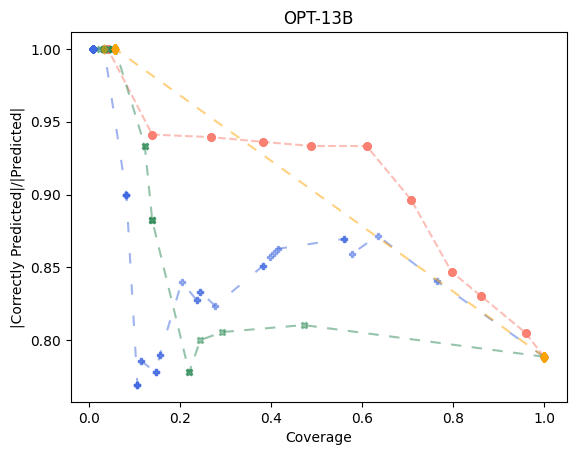

In [161]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0, (5, 5)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-13B")

## OPT30B

In [167]:
proxy_probar_auroc_opt30 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt30 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt30 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt30 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt30 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt30 = roc_auc_score(correctness, prob_true)

proxy probar 0.6992845117845118
norm_sem_ent_entail 0.5662878787878788
sem_ent_entail 0.5578703703703703
norm_pred_ent 0.42718855218855223
pred_ent 0.4234006734006734
prob_true 0.48821548821548816


Text(0.5, 1.0, 'OPT-30B Receiver Operator Characteristic Curve')

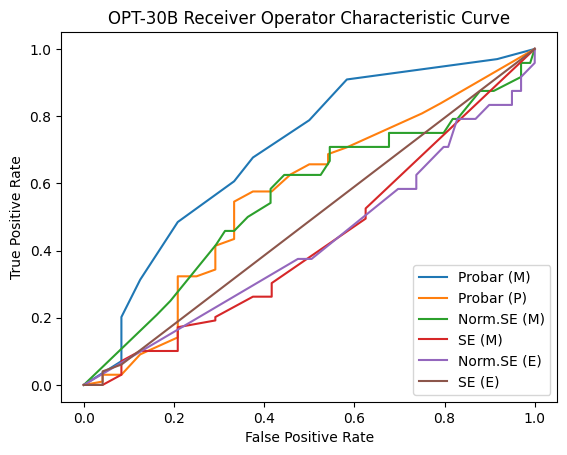

In [168]:
print('proxy probar',proxy_probar_auroc_opt30)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt30)
print('sem_ent_entail',entail_sem_ent_auroc_opt30)
print('norm_pred_ent',norm_pred_ent_auroc_opt30)
print('pred_ent',pred_ent_auroc_opt30)
print('prob_true',prob_true_auroc_opt30)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)','Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-30B Receiver Operator Characteristic Curve')

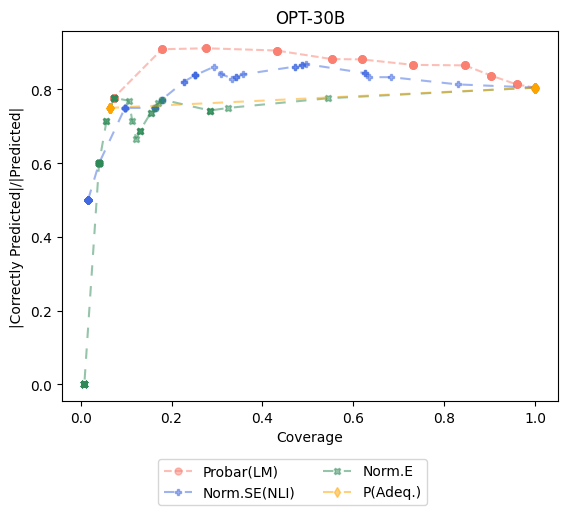

In [169]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 5)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
# plt.plot(coverage_norm_sem_ent, selective_performance_norm_sem_ent, label = 'Norm. SE(NC)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5)
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.E', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0, (5, 5)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

# plt.legend(loc='upper right')
plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-30B")
plt.legend(loc='lower right', ncol=2, bbox_to_anchor=(0.75, -0.3))

# Ambiguous + Non Ambiguous Test set

## OPT2.7B

In [175]:
proxy_probar_auroc_opt2_7 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt2_7 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt2_7 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt2_7 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt2_7 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt2_7 = roc_auc_score(correctness, prob_true)

proxy probar 0.7028472222222222
norm_sem_ent_entail 0.5999652777777778
sem_ent_entail 0.5960069444444445
norm_pred_ent 0.5013541666666667
pred_ent 0.5005902777777779
prob_true 0.4963194444444444


Text(0.5, 1.0, 'OPT-2.7B Receiver Operator Characteristic Curve')

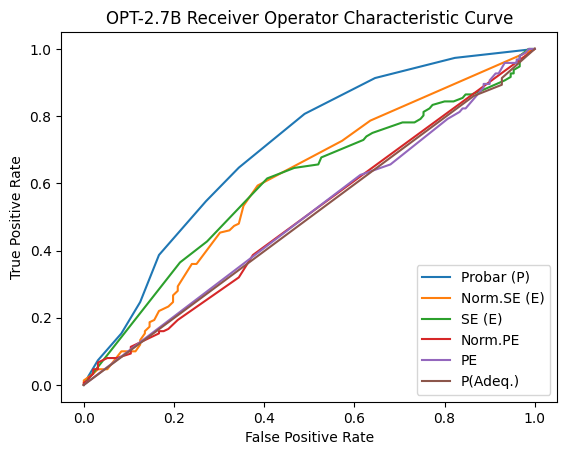

In [176]:
print('proxy probar',proxy_probar_auroc_opt2_7)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt2_7)
print('sem_ent_entail',entail_sem_ent_auroc_opt2_7)
print('norm_pred_ent',norm_pred_ent_auroc_opt2_7)
print('pred_ent',pred_ent_auroc_opt2_7)
print('prob_true',prob_true_auroc_opt2_7)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (P)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-2.7B Receiver Operator Characteristic Curve')

Text(0.5, 1.0, 'OPT-2.7B')

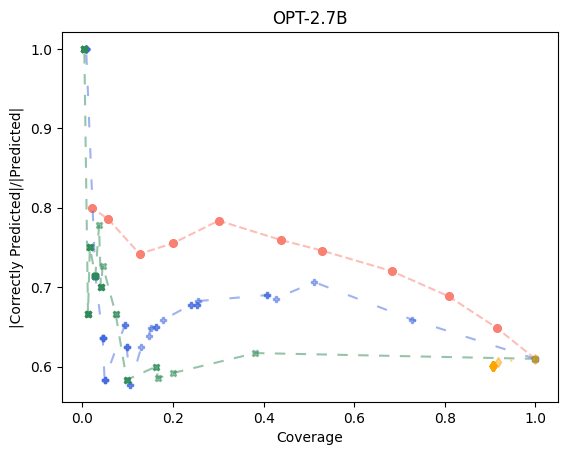

In [177]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0,(1,10)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-2.7B")


## OPT6.7B

In [183]:
proxy_probar_auroc_opt6_7 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt6_7 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt6_7 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt6_7 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt6_7 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt6_7 = roc_auc_score(correctness, prob_true)

proxy probar 0.7223453955182517
norm_sem_ent_entail 0.5975136590387204
sem_ent_entail 0.6059070393538681
norm_pred_ent 0.5527357668857391
pred_ent 0.5517063900546362
prob_true 0.5014648824134929


Text(0.5, 1.0, 'OPT-6.7B Receiver Operator Characteristic Curve')

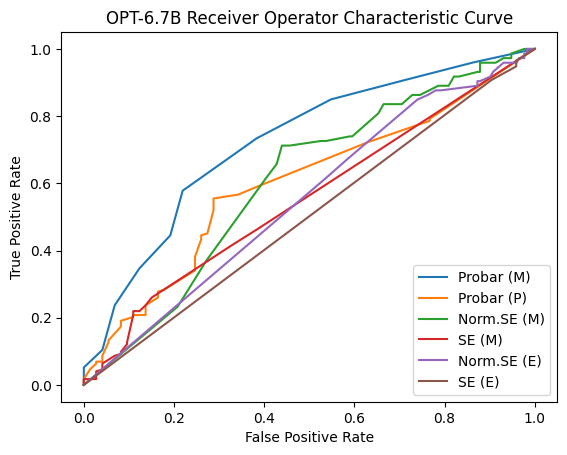

In [184]:
print('proxy probar',proxy_probar_auroc_opt6_7)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt6_7)
print('sem_ent_entail',entail_sem_ent_auroc_opt6_7)
print('norm_pred_ent',norm_pred_ent_auroc_opt6_7)
print('pred_ent',pred_ent_auroc_opt6_7)
print('prob_true',prob_true_auroc_opt6_7)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)', 'Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-6.7B Receiver Operator Characteristic Curve')

Text(0.5, 1.0, 'OPT-6.7B')

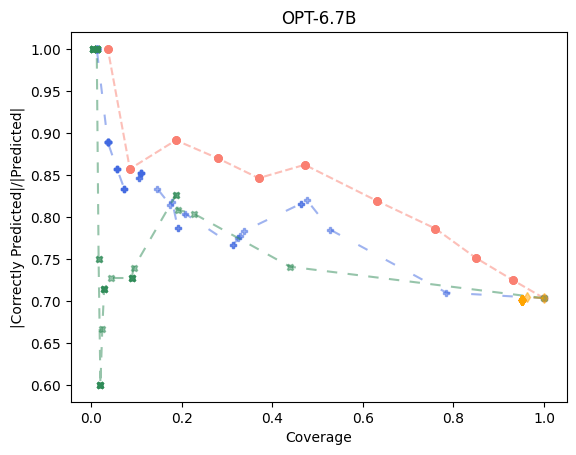

In [185]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0, (5, 5)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-6.7B")

## OPT13B

In [191]:
proxy_probar_auroc_opt13 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt13 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt13 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt13 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt13 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt13 = roc_auc_score(correctness, prob_true)

proxy probar 0.7337740384615385
norm_sem_ent_entail 0.6236263736263736
sem_ent_entail 0.6189474587912087
norm_pred_ent 0.5225789835164835
pred_ent 0.5244677197802199
prob_true 0.5307348901098901


Text(0.5, 1.0, 'OPT-13B Receiver Operator Characteristic Curve')

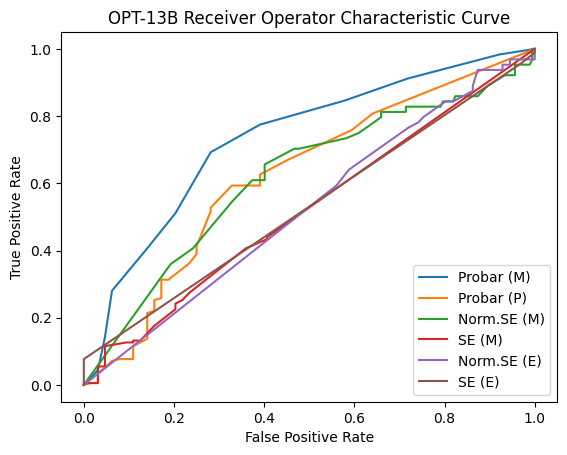

In [192]:
print('proxy probar',proxy_probar_auroc_opt13)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt13)
print('sem_ent_entail',entail_sem_ent_auroc_opt13)
print('norm_pred_ent',norm_pred_ent_auroc_opt13)
print('pred_ent',pred_ent_auroc_opt13)
print('prob_true',prob_true_auroc_opt13)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)','Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-13B Receiver Operator Characteristic Curve')

Text(0.5, 1.0, 'OPT-13B')

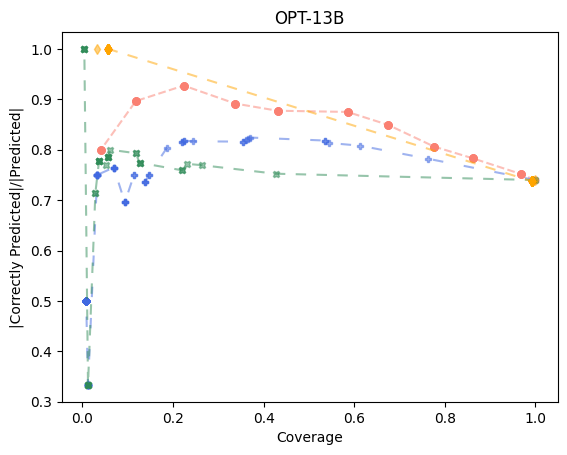

In [193]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 10)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.PE', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0, (5, 5)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-13B")

## OPT30B

In [199]:
proxy_probar_auroc_opt30 = roc_auc_score(correctness, probar)
entail_norm_sem_ent_auroc_opt30 = roc_auc_score(correctness, norm_sem_ent_entail)
entail_sem_ent_auroc_opt30 = roc_auc_score([1 - item for item in correctness], sem_ent_entail)
norm_pred_ent_auroc_opt30 = roc_auc_score(correctness, norm_pred_ent)
pred_ent_auroc_opt30 = roc_auc_score([1 - item for item in correctness], pred_ent)
prob_true_auroc_opt30 = roc_auc_score(correctness, prob_true)

proxy probar 0.6844093406593408
norm_sem_ent_entail 0.6317393543956045
sem_ent_entail 0.6282194368131868
norm_pred_ent 0.5607829670329669
pred_ent 0.5592376373626374
prob_true 0.5209048763736264


Text(0.5, 1.0, 'OPT-30B Receiver Operator Characteristic Curve')

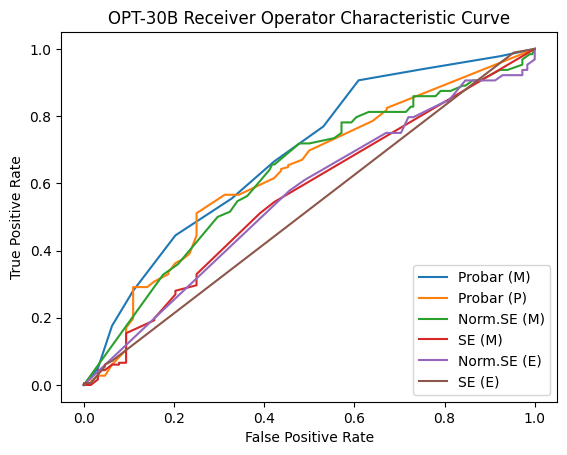

In [200]:
print('proxy probar',proxy_probar_auroc_opt30)
print('norm_sem_ent_entail', entail_norm_sem_ent_auroc_opt30)
print('sem_ent_entail',entail_sem_ent_auroc_opt30)
print('norm_pred_ent',norm_pred_ent_auroc_opt30)
print('pred_ent',pred_ent_auroc_opt30)
print('prob_true',prob_true_auroc_opt30)

plot_roc_curve(correctness, probar)
plot_roc_curve(correctness, norm_sem_ent_entail)
plot_roc_curve([1 - item for item in correctness], sem_ent_entail)
plot_roc_curve(correctness, norm_pred_ent)
plot_roc_curve([1 - item for item in correctness], pred_ent)
plot_roc_curve(correctness, prob_true)

plt.legend(['Probar (M)','Probar (P)','Norm.SE (M)','SE (M)', 'Norm.SE (E)','SE (E)','Norm.PE', 'PE', 'P(Adeq.)'], loc=('lower right'))
plt.title('OPT-30B Receiver Operator Characteristic Curve')

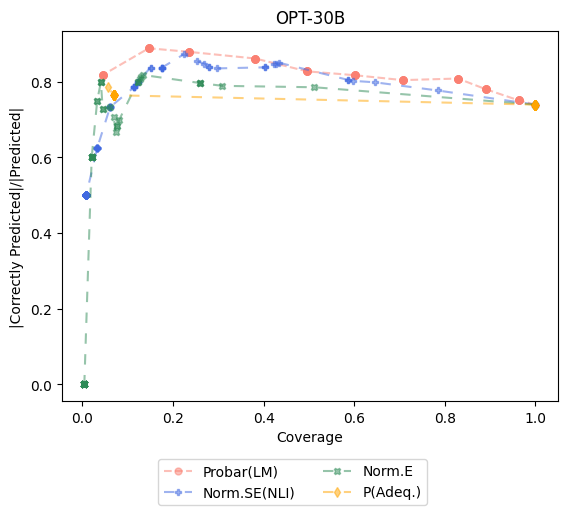

In [203]:
plt.plot(coverage_probar, selective_performance_probar, label = 'Probar(LM)', linestyle = 'dashed', marker='o', alpha = 0.5, markersize=5, color = 'salmon')
plt.plot(coverage_norm_sem_ent_entail, selective_performance_norm_sem_ent_entail, label = 'Norm.SE(NLI)', linestyle = (0, (5, 5)), marker='P', alpha = 0.5, markersize=5, color = 'royalblue')
plt.plot(coverage_norm_pred_ent, selective_performance_norm_pred_ent, label = 'Norm.E', linestyle = (0, (5, 5)), marker='X', alpha = 0.5, markersize=5,  color = 'seagreen')
plt.plot(coverage_prob_true, selective_performance_prob_true, label = 'P(Adeq.)', linestyle = (0, (5, 5)), marker='d', alpha = 0.5, markersize=5, color = 'orange')

plt.xlabel("Coverage")
plt.ylabel("|Correctly Predicted|/|Predicted|")
plt.title("OPT-30B")
plt.legend(loc='lower right', ncol=2, bbox_to_anchor=(0.75, -0.3))